<a href="https://colab.research.google.com/github/Zukumus/PredictPrice/blob/main/predict_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [327]:
# перводим в нужный тип, работаем с датами, переводим в тип ДАТА
aapl_df = pd.read_csv('/content/aapl.csv', parse_dates=['Date'])

In [328]:
print(aapl_df)

           Date       Open       High        Low      Close    Volume  OpenInt
0    1984-09-07    0.42388    0.42902    0.41874    0.42388  23220030        0
1    1984-09-10    0.42388    0.42516    0.41366    0.42134  18022532        0
2    1984-09-11    0.42516    0.43668    0.42516    0.42902  42498199        0
3    1984-09-12    0.42902    0.43157    0.41618    0.41618  37125801        0
4    1984-09-13    0.43927    0.44052    0.43927    0.43927  57822062        0
...         ...        ...        ...        ...        ...       ...      ...
8359 2017-11-06  171.75000  174.36000  171.10000  173.63000  34901241        0
8360 2017-11-07  173.29000  174.51000  173.29000  174.18000  24424877        0
8361 2017-11-08  174.03000  175.61000  173.71000  175.61000  24451166        0
8362 2017-11-09  174.48000  175.46000  172.52000  175.25000  29533086        0
8363 2017-11-10  175.11000  175.38000  174.27000  174.67000  25130494        0

[8364 rows x 7 columns]


In [329]:
aapl_df.head(2)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0


In [330]:
# выведим минимум и максимум
aapl_df['Date'].min(),aapl_df['Date'].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

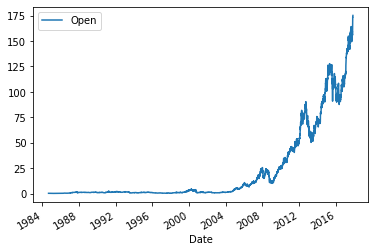

In [331]:
# вывести график зависимости  на старте и даты
aapl_df.plot(x='Date',y='Open')

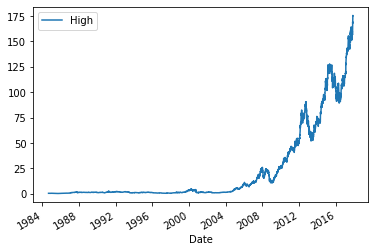

In [332]:
# вывести график зависимости цены максимум и даты
aapl_df.plot(x='Date',y='High')

In [333]:
# корреляци зависимости цен от показателей
aapl_df[['Open','Close','Low','High',	]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [334]:
# возьмём последние 6 лет 
aapl_df_6year=aapl_df[aapl_df['Date']>aapl_df['Date'].max()-timedelta(days=365*6)]

In [335]:
aapl_df_6year.shape

(1509, 7)

In [336]:
train_size = int(aapl_df_6year.shape[0]*0.8)
train_aapl_df = aapl_df_6year.iloc[:train_size]
test_aapl_df = aapl_df_6year.iloc[train_size:] 


In [337]:
train_aapl_df.shape, test_aapl_df.shape

((1207, 7), (302, 7))

In [338]:
train_aapl_df['Date'].min(),train_aapl_df['Date'].max(),test_aapl_df['Date'].min(),test_aapl_df['Date'].max(),

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

In [339]:
# масштабируем для нормализации из библиотеки Scikit-learn
scaler = StandardScaler()
scaler.fit(train_aapl_df[['Low']])

def make_dataset(
  # количество используемых элементов для предсказания следующего
    df,
  # размер партии элементов
    window_size,
  # размер партии элементов для обучения
    batch_size,
    use_scaler=True,
  # смешивание параметров
    shuffle=True
    ):
  # вычитаем признаки для предсказания
  features = df[['Low']].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
    # tensorflow
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      # берём лэйбл который предсказываем
      targets=df['Low'].iloc[window_size:],
    # сдвиг элементов для создания нового элемента, т.е. последовательность шагов
      sequence_length=window_size,
    # сдвиг элементов для создания нового элемента, т.е. последовательность шагов
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size,
      )
  return ds

In [340]:
example_ds = make_dataset(df=train_aapl_df,window_size=3,batch_size=2,use_scaler=False,shuffle=False)

In [341]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [342]:
example_feature.shape
# size batch
# size window
# size feature

(2, 3, 1)

In [343]:
example_label.shape

(2,)

In [344]:
train_aapl_df['Low'].iloc[:6]

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [345]:
print(example_feature[0])
print(example_label[0])
print(example_feature[1])
print(example_label[1])
# первые три элемента признак, следующй лабел. это настраивается

[[48.432]
 [48.592]
 [49.217]]
48.086000000000006
[[48.592]
 [49.217]
 [48.086]]
48.00899999999999


In [346]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_aapl_df,window_size=window_size,batch_size=batch_size,use_scaler=True,shuffle=True)
test_ds = make_dataset(df=test_aapl_df,window_size=window_size,batch_size=batch_size,use_scaler=True,shuffle=True)

In [347]:
# Sequential слои выполняються последовательно
lstm_model = tf.keras.models.Sequential([
# LSTM слой рекурентной сети,нужен когда важно обучение последовательно, на основании предыдузего опыта(текст, времённой ряд)
    tf.keras.layers.LSTM(32, return_sequences=False),
# Борьба с переобучением
    # tf.keras.layers.Dropout(0.2)
# приводим данные в один элемент(тот который ищем)
    tf.keras.layers.Dense(1)
])

In [348]:
def compile_and_fit(model, train_ds,test_ds,num_epochs: int=20):
  model.compile(
  # функция потерь для обучения
      loss=tf.losses.MeanAbsoluteError(),
  # оптимизатор потерь
      optimizer=tf.optimizers.Adam(),
  # вывод метрик и отклонений
      metrics=[tf.metrics.MeanAbsoluteError()]
  )
  history=model.fit(
  # на чём обучаме и сколько раз
      train_ds,
      epochs=num_epochs,
  # нужно для понимания, переобучается наша модель или нет(переобучение это плохо)
      validation_data=test_ds,
      verbose=0
  )
  return history

In [349]:
history = compile_and_fit(lstm_model,train_ds,test_ds,num_epochs=100)

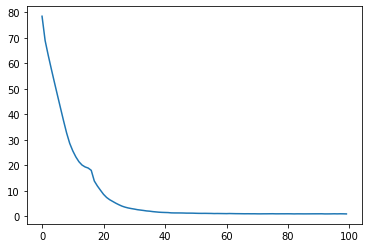

In [350]:
plt.plot(history.history['mean_absolute_error'])

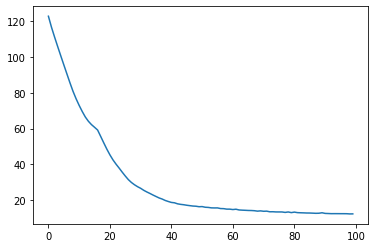

In [351]:
plt.plot(history.history['val_mean_absolute_error'])

In [352]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 3ms/step - loss: 1.0560 - mean_absolute_error: 1.0560


[1.0560221672058105, 1.0560221672058105]

In [353]:
lstm_model.evaluate(test_ds)

36/36 [==============================] - 0s 3ms/step - loss: 12.3736 - mean_absolute_error: 12.3736


[12.373579978942871, 12.373579978942871]

In [354]:
# Sequential слои выполняються последовательно
lstm_model = tf.keras.models.Sequential([
# LSTM слой рекурентной сети,нужен когда важно обучение последовательно, на основании предыдузего опыта(текст, времённой ряд)
    tf.keras.layers.LSTM(32, return_sequences=False),
# Борьба с переобучением
    tf.keras.layers.Dropout(0.2),
# приводим данные в один элемент(тот который ищем)
    tf.keras.layers.Dense(1),
])

In [ ]:
history = compile_and_fit(lstm_model,train_ds,test_ds,num_epochs=1000)

In [364]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 3ms/step - loss: 1.0391 - mean_absolute_error: 1.0391


[1.0391201972961426, 1.0391201972961426]

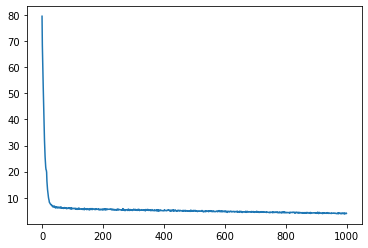

In [360]:
plt.plot(history.history['mean_absolute_error'])

In [359]:
lstm_model.evaluate(test_ds)

36/36 [==============================] - 0s 3ms/step - loss: 5.0972 - mean_absolute_error: 5.0972


[5.097174644470215, 5.097174644470215]

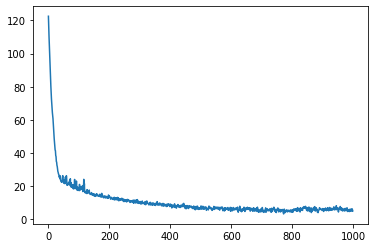

In [361]:
plt.plot(history.history['val_mean_absolute_error'])